---
title       : "Bootstrap"
subtitle    :
author      : Paul Schrimpf
date        : `j using Dates; print(Dates.today())`
bibliography: "ee.bib"
---

[![](https://i.creativecommons.org/l/by-sa/4.0/88x31.png)](http://creativecommons.org/licenses/by-sa/4.0/)

This work is licensed under a [Creative Commons Attribution-ShareAlike
4.0 International
License](http://creativecommons.org/licenses/by-sa/4.0/) 

### About this document 

This document was created using Weave.jl. The code is available in
[on github](https://github.com/schrimpf/GMMInference.jl). The same
document generates both static webpages and associated jupyter
notebooks [jupyter notebook](bootstrap.ipynb).

$$
\def\indep{\perp\!\!\!\perp}
\def\Er{\mathrm{E}}
\def\R{\mathbb{R}}
\def\En{{\mathbb{E}_n}}
\def\Pr{\mathrm{P}}
\newcommand{\norm}[1]{\left\Vert {#1} \right\Vert}
\newcommand{\abs}[1]{\left\vert {#1} \right\vert}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
\def\inprob{\,{\buildrel p \over \rightarrow}\,} 
\def\indist{\,{\buildrel d \over \rightarrow}\,} 
$$

In [1]:
markdown = try
  "md" in keys(WEAVE_ARGS) && WEAVE_ARGS["md"]
catch
  false
end

if !("DISPLAY" ∈ keys(ENV))
  # Make gr and pyplot backends for Plots work without a DISPLAY
  ENV["GKSwstype"]="nul"
  ENV["MPLBACKEND"]="Agg"
end

# Introduction

The bootstrap is a method of inference that utilizes resampling. The
basic idea is as follows. Suppose you have some parameter of interest
for which you want to do inference. Let $T_n$ denote some test
statistic involving the estimator. The test 
statistic is a function of data, so the distribution of the estimator
is a function of the distribution of data. Let $F_0$
denote the exact, finite sample distribution of the data. Let 
$$
G_n(\tau, F_0) = \Pr(\hat{\theta}_n \leq \tau)
$$
denote the exact finite sample distribution of the statistic. 
To do inference, we would like to know $G_n(\tau, F_0)$. 
This is generally impossible
without strong assumptions. Asymptotics get around this problem by
approximating $G_n(\tau, F_0)$ with its asymptotic distribution,
$G_\infty(\tau,F_0)$. The bootstrap is an alternative approach (but
the formal justification for the bootstrap still relies on
asymptotics). The bootstrap approximates $G_n(\tau, F_0)$ by replacing
$F_0$ with an estimate, $\hat{F}_n$. One common estimate of
$\hat{F}_n$ is simply the empirical CDF. When observations are
independent, we can randomly draw $T^*_n$ from 
$G_n(\tau, \hat{F}_n)$ by randomly drawing with replacement a sample
of size $n$ from the orgininal observations, and then computing
$T^*_n$ for this sample. We can do this repeatedly, and use
the distribution of the resulting $\hat{\theta}^*_n$'s to calculate
$G_n(\tau,\hat{F}_n)$. 


As a quick example, here's some code where the statistic is the sample
median minus its true value.

In [2]:
using Plots, StatsPlots, Distributions, Optim, ForwardDiff, LinearAlgebra, GMMInference
Plots.gr();

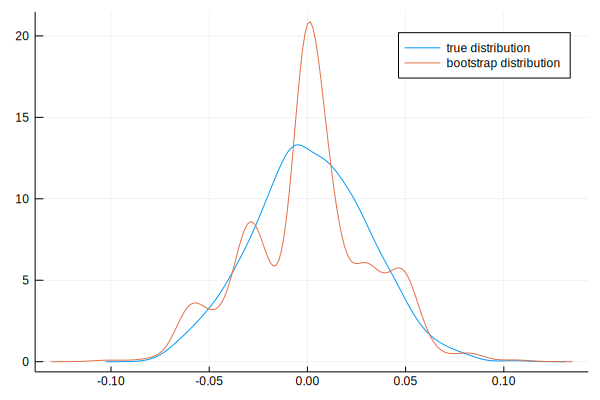

In [3]:
dgp(n) = rand(n).^2
estimator(x) = median(x)
# simulating T ~ G_n(τ,F_0)
n = 300
S = 1000
T = [estimator(dgp(n)) for s in 1:S] .- 0.25
function bootstrap(data, estimator, S)
  n = length(data)
  θhat = estimator(data)
  T = [estimator(sample(data,n, replace=true)) for s in 1:S] .- θhat 
end
Tboot = bootstrap(dgp(n),estimator, S)
density(T, label="true distribution")
density!(Tboot, label="bootstrap distribution")

## References

Mackinnon (2006)[@mackinnon2006] and MacKinnon (2009)[@mackinnon2009] are good practical introductions to
the bootstrap. Horowitz (2001)[@horowitz2001] is also a good overview, and includes
more precise statements of theoretical results, but does not contain
proofs. The lecture notes of Shi (2012)[@shi2012] are another very good overview.
Gine (1997)[@gine1997] is a rigorous and fairly self-contained theoretical
treatment of the bootstrap.

Although the bootstrap works in many situations, it does not always
work. For example, Abadie and Imbens (2008)[@abadie2008] show the
failure of the bootstrap for matching estimators. See Andrews
(2000)[@andrews2000], Andrews and Han (2009)[@andrews2009], and Romano
and Shaikh (2012)[@romano2012] for theoretical developments on
situations where the bootstrap fails and alternatives that work.  Hall
(1994)[@hall1994] gives a theoretical overview of when the bootstrap
provides asymptotic refinement. Chernozhukov, Chetverikov, and Kato
(2017)[@chernozhukov2017] discusses the bootstrap in high dimensional
models.

# Theory

This section follows the approach Van der Vaart (2000)[@van2000]. We focus on the case where
$T_n = \frac{\hat{\theta}_n - \theta_0}{\hat{\sigma}_n}$ is a
t-statistic. A simple and useful result is that if $T_n$ and $T^*_n$
both converge to the same distribution, then the bootstrap is
consistent. 

!!! tip "**Theroem**: bootstrap consistency"
    Suppose that 
    $$
    T_n = \frac{\hat{\theta}_n - \theta_0}{\hat{\sigma}_n} \leadsto T
    $$
    and 
    $$
    T_n^* =  \frac{\hat{\theta}^*_n - \hat{\theta}_n}{\hat{\sigma}^*_n} \leadsto T
    $$
    conditional on the data, for some random variable $T$ with a
    continuous distribution function. Then 
    $$
    | G_n(\tau, F_0) - G_n(\tau,\hat{F}_n) | \inprob 0 |
    $$
    and in particular,
    $$
    \Pr(\theta_0 \in [\hat{\theta}_n - G_n^{-1}(\alpha/2, \hat{F}_n)
    \hat{\sigma}_n ,  \hat{\theta}_n - G_n^{-1}(1-\alpha/2, \hat{F}_n)
    \hat{\sigma}_n ]) \to 1-\alpha.
    $$


*Proof sketch:* $T_n$ and $T_n^\ast$ both $\leadsto T$ immediately
implies $G_n(\tau, F_0) \inprob G_\infty(\tau)$ and
$G_n(\tau,\hat{F}_n) \inprob G_\infty(\tau)$, where $G_\infty(\tau)$
is the CDF of $T$. This implies that 
$G^{-1}_n(\tau,\hat{F}_n) \inprob G^{-1}_\infty(\tau)$ for all $\tau$
where $G_\infty$ is continuous. Then we have
$$
\Pr(\theta_0 \geq \hat{\theta}_n - G_n^{-1}(\tau, \hat{F}_n)
 \hat{\sigma}_n) = \Pr\left(\frac{\theta_0 -
 \hat{\theta}_n}{\hat{\sigma}_n} \leq G_n^{-1}(\tau, \hat{F}_n)\right) \to
 \Pr(T \leq G^{-1}_\infty(\tau)) = \tau.
$$

This theorem is very simple, but it is useful because it suggest a
simple path to showing the consistency of the bootstrap: simply show
that $T_n^\ast$ has the same asymptotic distribution as $T_n$. Here is a
simple result for when $T_n^\ast$ is constructed by sampling with
replacement from the empirical distribution. We will let
$\mathbb{P}_n$ denote the empirical distribution, and $x_i^\ast$ denote
draws of $x_i$ from it.

!!! tip "**Lemma**"
    Let $x_1, x_2, ...$ be i.i.d. with mean $\mu$ and variance
    $\sigma^2$. Then conditional on $x_1, ...$ for almost every sequence
    $$
    \sqrt{n} (\bar{x}_n^* - \bar{x}_n) \indist N(0,\sigma^2)
    $$

**Proof sketch** it is straightforward to show that $\Er[x_i^\ast |
\mathbb{P}_n] = \bar{x}_n$ and $Var(x_i^\ast|\mathbb{P}_n) = \bar{x^2}_n
- \bar{x}_n^2 \to \sigma^2$. Applying the Lindeberg CLT then gives the
result.


## Pivotal statistics

The above results imply that the bootstrap works for both 
$S_n = \sqrt{n}(\bar{x}_n - \mu_0)$ and "studentized" a statistic 
$T_n = \sqrt{n}(\bar{x}_n - \mu_0)/\hat{\sigma}_n$. There is some
advantage to using the later. A statistic is called pivotal if its
distribution is completely known. If we assume $x_i \sim N$, then
$T_n$ is pivotal and has a t-distribution. If we aren't willing to
assume normality, then the distribution of $T_n$ is unknown, but its
asymptotic distribution is completely known, $N(0,1)$. Such a
statistic is called asymptotically pivotal. $S_n$ is not
asymptotically pivotal because its asymptotic distribution depends on
the unknown variance. It is possible to show that the bootstrap
distribution of asymptotically pivotal statistics converge faster than
either the usual asymptotic approximation or the bootstrap distribution of
non-pivotal statistics. See Hall (1994)[@hall1994] for details. 

Here is a simulation to illustrate.

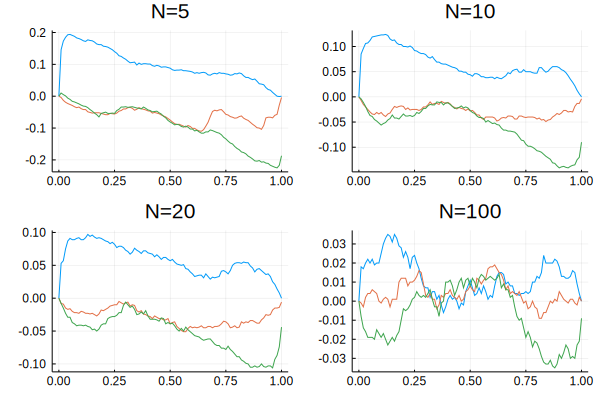

In [4]:
dgp(n) = rand(Exponential(),n)
estimator(x) = mean(x)
θ0 = 1.0
N = [5 10 20 100]
B = 999
function simulatetests(n)
  function bootstrap(data, stat, S)
    n = length(data)
    T = [stat(sample(data,n)) for s in 1:S]
  end
  data = dgp(n)
  t = sqrt(n)*(mean(data)-θ0)/std(data)
  [cdf(Normal(),t),
   mean(t.<bootstrap(data, d->(sqrt(n)*(mean(d) - mean(data))/std(d)), B)),
   mean((mean(data)-θ0) .< bootstrap(data, d->(mean(d)-mean(data)), B))]
end
res=[hcat([simulatetests.(n) for s in 1:1000]...) for n in N]

p = 0:0.01:1
global fig = plot(layout=4, legend=:none)
for i=1:4
  plot!(fig,p, p->(mean(res[i][1,:].<p)-p), title="N=$(N[i])",
        label="asymptotic", subplot=i)
  
  plot!(fig,p, p->(mean(res[i][2,:].<p)-p), title="N=$(N[i])",
        label="pivotal bootstrap", subplot=i)
  plot!(fig,p, p->(mean(res[i][3,:].<p)-p), title="N=$(N[i])",
        label="non-pivotal boostrap", subplot=i)
end
fig

This figure shows the simulated CDF of p-values minus p. For a
perfectly sized test, the line would be identically 0. The blue lines
are for the usual t-test. Green is from bootstrapping the non-pivotal
statistic $\sqrt{n}(\bar{x}^\ast - \bar{x})$. Red is from bootstrapping a
pivotal t-statistic. As expected, the red line is closer to 0,
illustrating the advantage of bootstrapping a pivotal statistic. 

## Bootstrap does not always work

It is important to remember that the bootstrap is not guaranteed to
work. A classic example is estimating the mean squared. 
Let $x_i \sim F_0$, where$F_0$ is any distribution with mean
$\mu$ and variance $\sigma^2$. The parameter of interest is $\theta = \mu^2$. The estimator
will be $\hat{\theta} = \bar{x}^2$.  The delta method and CLT imply 
$$
    \sqrt{n}(\bar{x}^2 - \mu^2) \indist 2\mu N(0,\sigma^2)
$$
similarly conditional on the data,
$$
    \sqrt{n}(\bar{x^\ast}^2 - \bar{x}^2) \indist 2 \mu N(0,\sigma^2)$
$$
A problem occurs when $\mu=0$. The limiting distributions become point
masses at 0. The CDF is no longer continuous, so the theorem above
does not apply. 

Here's an illustration

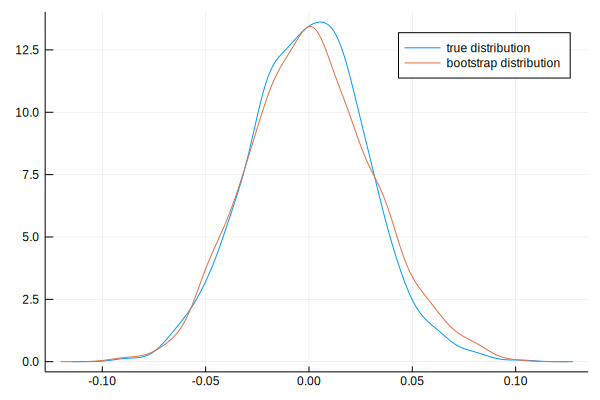

In [5]:
function bootmeansquared(μ0, n)
  dgp(n) = rand(n) .- 0.5 .+ μ0
  estimator(x) = mean(x)^2  
  S = 1000
  T = [estimator(dgp(n)) for s in 1:S] .- μ0^2
  function bootstrap(data, estimator, S)
    n = length(data)
    θhat = estimator(data)
    [estimator(sample(data,n,replace=true)) for s in 1:S] .- θhat 
  end
  Tboot = bootstrap(dgp(n),estimator, S)
  density(T, label="true distribution")
  density!(Tboot, label="bootstrap distribution")
end
bootmeansquared(0.5,100)

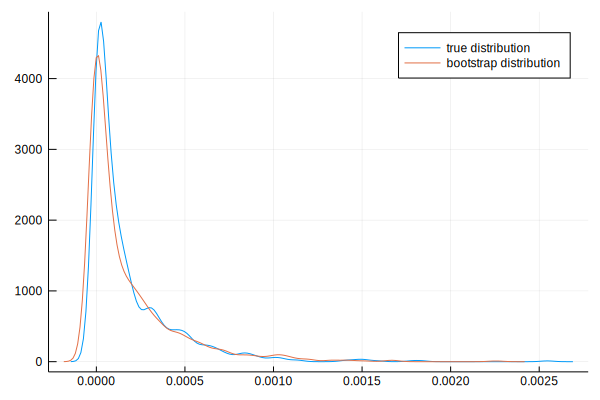

In [6]:
bootmeansquared(0.0,500)

Depending on the random numbers drawn (in particular, whether the simulated
sample mean is very close to 0 or not), the above picture may look
okay or terrible for the bootstrap. Try running it a few times to get
a sense of how bad it might be.

# Bootstrap for GMM

## Joint hypotheses

The failure of the bootstrap for the mean squared when the true mean
is 0 has important implications for GMM. In particular, the AR
statistic, 

$$
AR(\theta) = n [1/n \sum g_i(\theta)]' \widehat{Var}(g_i(\theta))^{-1}
[1/n \sum g_i(\theta)] 
$$

is essentially a mean squared. If we naively attempt to apply the
bootstrap by computing

$$
AR(\theta)^* = n [1/n \sum g_i^*(\theta)]' \widehat{Var}(g_i^*(\theta))^{-1}
[1/n \sum g_i^*(\theta)] 
$$

we will get incorrect inference. The problem is that we want to test
$H_0: \Er[g_i(\theta)] = 0$, but in the bootstrap sample, 

$$
\Er[g^*(\theta)|data] = 1/n \sum g_i(\theta) \neq 0.
$$

For the bootstrap to work, we must ensure that the null hypothesis is
true in the bootstrap sample, we can do this by taking

$$
AR(\theta)^* = n [1/n \sum g_i^*(\theta) - \bar{g}_n(\theta)]' \widehat{Var}(g_i^*(\theta))^{-1}
[1/n \sum g_i^*(\theta) - \bar{g}_n(\theta)] 
$$

where $\bar{g}_n(\theta) = 1/n \sum g_i(\theta)$. 

Here is a simulation to illustrate. It uses the same IV-logit share
example as in the extremum estimation notes.

In [7]:
n = 100
k = 2
iv = 3
β0 = ones(k)
π0 = vcat(I,ones(iv-k,k))
ρ = 0.5
data = IVLogitShare(n,β0,π0,ρ)

function arstat(gi)
  n = size(gi)[1]
  gn = mean(gi,dims=1) 
  W = pinv(cov(gi))
  n*( gn*W*gn')[1]
end

function ar(θ,gi)
  n,m = size(gi(θ))
  1.0-cdf(Chisq(m), arstat(gi(θ)))
end

function bootstrapAR(θ,gi)
  giθ = gi(θ)
  gn = mean(giθ,dims=1)
  n = size(giθ)[1]
  S = 999
  T =hcat([ [arstat(giθ[sample(1:n,n,replace=true),:]),
             arstat(giθ[sample(1:n,n,replace=true),:].-gn)
             ] for s in 1:S]...)'
  t = arstat(giθ)
  [1-cdf(Chisq(length(gn)),t)  mean(T.>=t, dims=1)]
end

function simulatetests()
  data = IVLogitShare(n,β0,π0,ρ)
  bsp=bootstrapAR(β0, get_gi(data))
end

simulatetests (generic function with 2 methods)

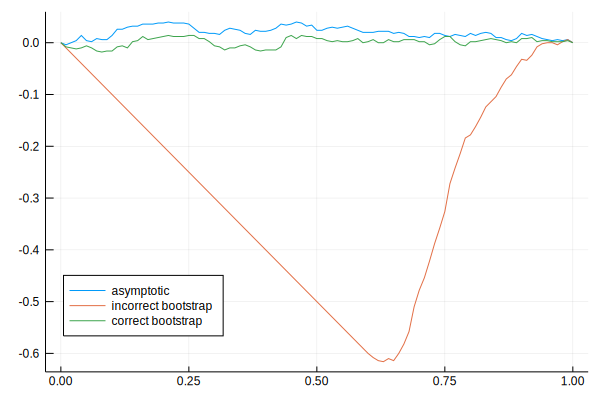

In [8]:
pvals = vcat([simulatetests() for s in 1:500]...)
p = 0:0.01:1.0
plot(p, p->(mean(pvals[:,1].<p)-p),  label="asymptotic", legend=:bottomleft)
plot!(p, p->(mean(pvals[:,2].<p)-p),  label="incorrect bootstrap")
plot!(p, p->(mean(pvals[:,3].<p)-p),  label="correct bootstrap")

With the same sort of modification the KLM and CLR statistics can also
be bootstrapped. All three statistics remain identification robust
when bootstrapped. See Kleibergen (2006)[@kleibergen2006] for details.

## Single coefficients

If we want to construct a confidence interval for a single
coefficient, we can apply the bootstrap to a statistic like 
$\sqrt{n} (\hat{\theta} - \theta_0)$ (or a studentized version of
it). Just like in the previous subsection, we must be careful to
ensure that the null hypothesis holds in the bootstrapped data. Also,
as above, we can do this by subtracting $1/n\sum_i g_i(\hat{\theta})$
from the bootstrapped moments. Thus, one way to bootstrap is 
$\sqrt{n} (\hat{\theta} - \theta_0)$ is to

- Compute $\hat{\theta}$, $\bar{g}_n(\theta) = 1/n\sum_i g_i(\hat{\theta})$
- Draw with replacement $g_i^*(\theta)$ from $\{g_i(\theta) -
  \bar{g}_n(\theta)\}_{i=1}^n$. 
- Compute 

$$\hat{\theta}^* = \argmin [1/n \sum_i g_i^*(\theta)] W_n^*(\theta)
  [1/n \sum g_i^*(\theta]$$
  
- Use distribution of $\sqrt{n} (\hat{\theta}^* - \hat{\theta})$ to
  approximate $\sqrt{n} (\hat{\theta} - \theta_0)$

For some models, the minimazation needed to compute $\hat{\theta}^*$
can be very time consuming. Fortunately, it can be avoided. A key step
in showing that $\hat{\theta}$ is asymptotically normal is a
linearization

$$
\sqrt{n}(\hat{\theta} - \theta_0) = -(D'WD)^{-1} (D' W)
\frac{1}{\sqrt{n}} \sum_i g_i(\theta_0) + o_p(1) 
$$

Showing the bootstrap estimator is asymptotically normal conditional
on the data involves a similar linearization

$$
\sqrt{n}(\hat{\theta}^* - \hat{\theta}) = -(\hat{D}'\hat{W}\hat{D})^{-1} (\hat{D}' \hat{W})
\frac{1}{\sqrt{n}} \sum_i g_i^*(\hat{\theta}) + o_p(1) 
$$

This suggests taking 

$$
\hat{\theta}^* = \hat{\theta} + (\hat{D}'\hat{W}\hat{D})^{-1} (\hat{D}' \hat{W})
\frac{1}{\sqrt{n}} \sum_i g_i^*(\hat{\theta}) 
$$

instead of re-minimizing.

In [9]:
function gmmVar(θ,gi,W)
  g = gi(θ)
  n = size(g)[1]
  D = ForwardDiff.jacobian(θ->mean(gi(θ),dims=1),θ)
  Σ = cov(gi(θ))
  1/n*inv(D'*W*D)*(D'*W*Σ*W*D)*inv(D'*W*D)
end

function bsweights(n)
  s = sample(1:n,n)
  (x->sum(x.==s)).(1:n)
end


function bootstrapt(θ,gi, W)
  giθ = gi(θ)
  gn = size(giθ)[1]
  D = ForwardDiff.jacobian(θ->mean(gi(θ),dims=1),θ) 
  function bootonce(θ,gi)
    giθ = gi(θ)
    n = size(giθ)[1]
    gn = mean(giθ,dims=1)
    w = bsweights(n)
    giw(θ) = (gi(θ).*w .- gn)
    gmmobj = gmm_objective(giw, W)
    opt1 = optimize(gmmobj, θ, BFGS(), autodiff =:forward)
    θs1 = opt1.minimizer
    θs2 = θ - inv(D'*W*D)*(D'*W*( (mean(giθ.*w,dims=1).-gn)' ))
    [θs1[1] θs2[1]]
  end
  S = 299
  vcat([bootonce(θ,gi) for s in 1:S]...)
end

bootstrapt (generic function with 1 method)

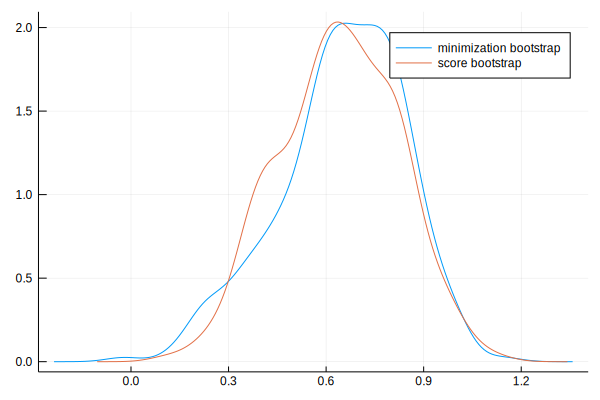

In [10]:
n = 50
k = 2
iv = 3
β0 = ones(k)
π0 = vcat(I,ones(iv-k,k))
ρ = 0.5
data = IVLogitShare(n,β0,π0,ρ)
gi = get_gi(data)
W = I
optres = optimize(gmm_objective(data,W), β0, BFGS(),
                  autodiff = :forward)
θhat = optres.minimizer
θs = bootstrapt(θhat,gi,I)
density(θs[:,1], label="minimization bootstrap")
density!(θs[:,2], label="score bootstrap")

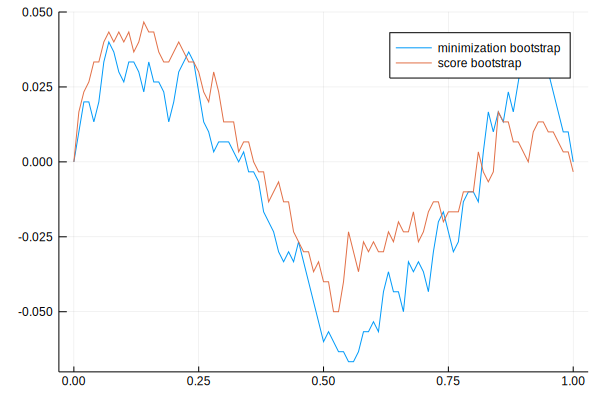

In [11]:
function simulatetests()
  data = IVLogitShare(n,β0,π0,ρ)
  gi = get_gi(data)
  W = I
  optres = optimize(gmm_objective(gi,W), β0, BFGS(), autodiff =:forward)
  θhat = optres.minimizer 
  θs = bootstrapt(θhat,gi,I)
  p = mean((θhat[1]-β0[1]).<(θs .- θhat[1]), dims=1)
end

pvals = vcat([simulatetests() for s in 1:300]...)
p = 0:0.01:1.0
fig=plot(p, p->(mean(pvals[:,1].<p)-p),
         label="minimization bootstrap", legend=:best)
plot!(fig,p, p->(mean(pvals[:,2].<p)-p),  label="score bootstrap")
fig

Both versions of the bootstrap appear to work well enough here. Note
that neither one is robust to identification problems. Inference on a
subset of parameters while remaining robust to identification problems
is somewhat of an open problem. Various conservative approaches are
available, the simplest of which is to just take projections of the
AR, KLM, or CLR confidence sets. There are also more powerful
approaches for situations where you know which parameters are strongly
vs weakly identified. 


# References 

\bibliography